In [3]:
!pip install wordninja

In [39]:
import pandas as pd
import numpy as np


import zipfile
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('bmh')

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV


import nltk
import wordninja
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


I will be using the dataset from: https://ai.stanford.edu/~amaas/data/sentiment/ - The dataset is extracted from IMDB and contains a total of 50,000 highly polar movie reviews. The initial dataset is divided into 25,000 for training and 25,000 for testing.

After downloading the dataset, which was in .tar.gz format, I locally extracted it, cleaned some unnesscary files and then recompressed it into .zip for better functionality.

In [5]:
# Extracting Zip File

zip_path = "dataset.zip"
extract_path = "/content/"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    print(f"Extracting files...\n")
    for file in tqdm(file_list):
        zip_ref.extract(file, extract_path)

print("\nExtraction complete.")

# Don't mind the number if it says 100008 files being extracted, the dataset also contains some 'unsup' folder with 50k untagged reviews -_-

Extracting files...



100%|██████████| 100008/100008 [00:39<00:00, 2515.97it/s]


Extraction complete.


# Loading & Combining into One Dataframe
For a better ease of access and understanding, what I am going to do is; I am going to combine the entire dataset into one dataframe with 2 columns, namely: reviews and sentiment - with 1 indicating postive and 0 negative

Why? Because currently, the dataset is divided into train and test folders and each containing sub folders with 'pos' and 'neg' reviews and this could prove to be tedious when going ahead with pre-processing.  

And I can always spilit the newly combined dataframe into train_test using scikit learn after pre-processing

In [6]:
def load_reviews_from_folder(folder_path, sentiment_label):
    data = []
    filenames = sorted(os.listdir(folder_path))

    for filename in tqdm(filenames, desc=f"Loading from {os.path.basename(folder_path)}"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            review = file.read()
            data.append((review, sentiment_label))

    return data

# Paths for train and test (both positive and negative)
base_path = "/content/dataset"
datasets = []

for split in ["train", "test"]:
    print(f"\n🔹 Processing {split} data...")

    pos_path = os.path.join(base_path, split, "pos")
    neg_path = os.path.join(base_path, split, "neg")

    datasets.extend(load_reviews_from_folder(pos_path, 1))  # Positive = 1
    datasets.extend(load_reviews_from_folder(neg_path, 0))  # Negative = 0

# Combine into DataFrame
df = pd.DataFrame(datasets, columns=["review", "sentiment"])

# Shuffle (why not?)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

df.head()



🔹 Processing train data...


Loading from neg: 100%|██████████| 12500/12500 [00:00<00:00, 36388.77it/s]



🔹 Processing test data...


Loading from neg: 100%|██████████| 12500/12500 [00:00<00:00, 35775.24it/s]


,review,sentiment
0,Fame is one of the best movies I've seen about...,1
1,This movie fully deserves to be one of the top...,1
2,"in a time of predictable movies, in which abou...",1
3,I saw this on TV the other night or rather I ...,0
4,I am a huge fan of Simon Pegg and have watched...,1


In [7]:
df.count()

,0
review,50000
sentiment,50000


In [8]:
df.info() # sentiment column is int already - just a note

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [9]:
df.isnull().sum()

,0
review,0
sentiment,0


In [10]:
# Manually Checking review against its sentiment value
print(f"The review is:\n{df['review'][2]}. \nThe sentiment is\n{df['sentiment'][2]}")

The review is:
in a time of predictable movies, in which abound violence, cheap romance and melodrama, it is delightfully surprising to find such a strange movie. the plot itself is compelling, and the actors are excellent, especially Alan Rickman. If you want to watch a movie that does not provide all the answers before asking the questions, a movie that will surprise you (in good or bad), Dark Harbor's for you. And if you're not convinced, believe me that Alan Rickman's performance is well worth it... especially at the end, ladies..... 
The sentiment is
1


In [11]:
# Checking review against its sentiment value
print(f"The review is:\n{df['review'][3]}. \nThe sentiment is\n{df['sentiment'][3]}")

The review is:
I saw this on TV the other night or rather I flicked over to another channel every so often to watch infomercials when I couldn't stand watching it any longer. It was bad. Really, really bad. Not "so bad it's good" just flat out bad. How did it get funded? Who thought this was a good idea? An actor friend of mine auditioned and was told he wasn't good enough to play a bad guy but I think what they meant was "save yourself and runaway from this steaming pile of @#$%." I bet the rest of the cast had been given the option. To be fair the acting was hard to judge because of the appalling fake American ascents. The shooting was dullllllllllll. The action was awkward and stilted. The dialog was inane. By far the saddest thing was ship. In real life the Interislander ferry is a shabby boat and on film it doesn't scrub up well. Instead of trying very unsuccessfully to make it look like a new crews liner with bits of tinsel wrapped around rusting polls, I kid you not, they could

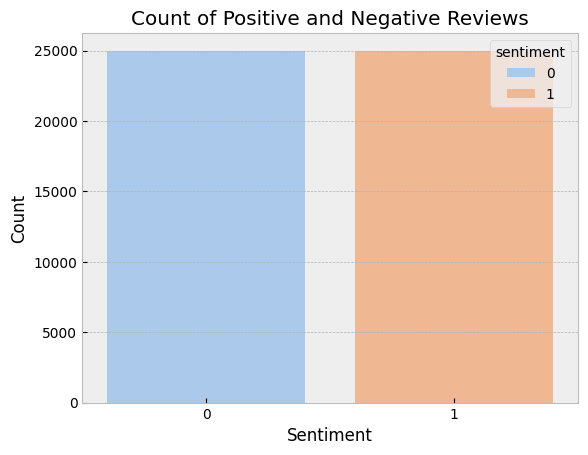

In [12]:
sns.countplot(x='sentiment', data=df, hue='sentiment', palette='pastel')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Count of Positive and Negative Reviews")
plt.show()

The dataset is balanced. And yep! Now we have total of 50,000 reviews and their sentiments perfectly in a dataframe. Now off to pre-processing.

# Pre-Processing

So this function cleans and lemmatizes (*I am using lemmatizer since I need accuracy over speed*) text data in a DataFrame, removing noise like HTML, URLs, punctuation, and stopwords, then stores the processed text in a new column with a progress bar - So I can monitor the progress :).




In [13]:
def preprocess_text(df, text_column='review'):
    """
    Parameters:
    ------
    df : pandas DataFrame
        DataFrame containing the text data
    text_column : str, default='review'
        Name of the column containing the text to preprocess

    Returns:
    --------
    pandas DataFrame
        DataFrame with preprocessed text in a new column 'processed_text'
    """

    processed_df = df.copy()

    lemmatizer = WordNetLemmatizer() # I am using Lemmatizer for better accuracy

    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        text = text.lower() # Convert to lowercase

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        words = text.split()

        # Split glued words using wordninja - Some words were joined together, so I had to modify and add worninja
        split_words = []
        for word in words:
          split_words.extend(wordninja.split(word))

        # Remove stopwords and lemmatize
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

        # Join words back into text
        return ' '.join(words)

    # Apply preprocessing to the text column
    tqdm.pandas(desc="Preprocessing text")
    processed_df['processed_text'] = processed_df[text_column].progress_apply(clean_text)
    cols = [col for col in processed_df.columns if col != 'sentiment'] + ['sentiment'] # To move the sentiment col at the end for better readability
    processed_df = processed_df[cols]

    return processed_df

In [14]:
processed_df = preprocess_text(df) # Might take some time because of worninja
# I am using Colab so the compute power is enough to perfrom the func in less than 4 mins

Preprocessing text: 100%|██████████| 50000/50000 [04:33<00:00, 182.86it/s]


In [15]:
processed_df['processed_text'][0]

'fame one best movie ive seen performing art music acting excellent screenplay set design also excellent favorite part student start dancing making music canteen see movie number time never get bored give'

In [16]:
processed_df['processed_text'][2]

'time predictable movie abound violence cheap romance melodrama delightfully surprising find strange movie plot compelling actor excellent especially alan rickman want watch movie provide answer asking question movie surprise good bad dark harbor youre convinced believe alan rickmans performance well worth especially end lady'

## Checking for Duplicates

In [17]:
duplicates = processed_df.duplicated().sum()
duplicates

np.int64(418)

In [18]:
processed_df = processed_df.drop_duplicates()

print(f"Dropped total of {duplicates} duplicates")

Dropped total of 418 duplicates


In [19]:
processed_df.count()

,0
review,49582
processed_text,49582
sentiment,49582


## Splitting Data

I will do it in a rather un-traditional way. For the splitting part, I will split into four different groups: **full_train, train, validation and test**.

The idea is to have train and validation for training and then pefroming hyper-parameter tuning on the validation. Once I have selected which ML algo performs best and with the suitable hyper-parameter, I will then train that model using specific parameters on the full_train and test data so that it takes more data into account for the final training.


In [20]:
X = processed_df['processed_text'] # containing our processed text column
y = processed_df['sentiment'] # our target variables

In [21]:
tqdm.pandas() # who doesn't love a progress bar?

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(tqdm(X, desc="Vectorizing Text"))

Vectorizing Text: 100%|██████████| 49582/49582 [00:05<00:00, 8489.48it/s] 


In [22]:
# Split into full_train (80%) and test (20%)
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X_vectorized, y,
    test_size=0.2,
    random_state=1,
    stratify=y  # to keep classes balanced
)

# Split full_train into train (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_full_train, y_full_train,
    test_size=0.25,  # 25% of 80% = 20% of total
    random_state=1,
    stratify=y_full_train
)

In [23]:
print(X_full_train.shape, y_full_train.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(39665, 203225) (39665,)
(29748, 203225) (29748,)
(9917, 203225) (9917,)
(9917, 203225) (9917,)


# Training The Model (Selecting Best Algo)

In [24]:
def run_text_classification_pipeline(X_train, X_val, y_train, y_val):

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Multinomial NB": MultinomialNB(),
        "Linear SVC": LinearSVC(),
        "LightGBM": LGBMClassifier()
    }

    f1_scores = []

    print("\nModel Results:\n")
    for name, model in models.items():
        print(f"-- {name}")

        for _ in tqdm(range(1), desc=f"{name} Training", leave=False):
          model.fit(X_train, y_train)
          preds = model.predict(X_val)


        acc = accuracy_score(y_val, preds)
        prec = precision_score(y_val, preds, zero_division=0)
        rec = recall_score(y_val, preds, zero_division=0)
        f1 = f1_score(y_val, preds, zero_division=0)

        f1_scores.append((name, f1))

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall : {rec:.4f}")
        print(f"F1-score : {f1:.4f}\n")



    # Plot F1 scores
    f1_scores.sort(key=lambda x: x[1])
    model_names, f1_values = zip(*f1_scores)

    plt.figure(figsize=(10, 5))
    plt.barh(model_names, f1_values, color='skyblue')
    plt.xlabel("F1 Score")
    plt.title("Model Comparison (F1 Scores)")
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()



Model Results:

-- Logistic Regression


Accuracy : 0.8852
Precision: 0.8772
Recall : 0.8969
F1-score : 0.8869

-- Multinomial NB


Accuracy : 0.8570
Precision: 0.8640
Recall : 0.8487
F1-score : 0.8563

-- Linear SVC


Accuracy : 0.8877
Precision: 0.8826
Recall : 0.8953
F1-score : 0.8889

-- LightGBM


LightGBM Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 14930, number of negative: 14818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.157922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564350
[LightGBM] [Info] Number of data points in the train set: 29748, number of used features: 11735
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501882 -> initscore=0.007530
[LightGBM] [Info] Start training from score 0.007530


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy : 0.8514
Precision: 0.8439
Recall : 0.8636
F1-score : 0.8536



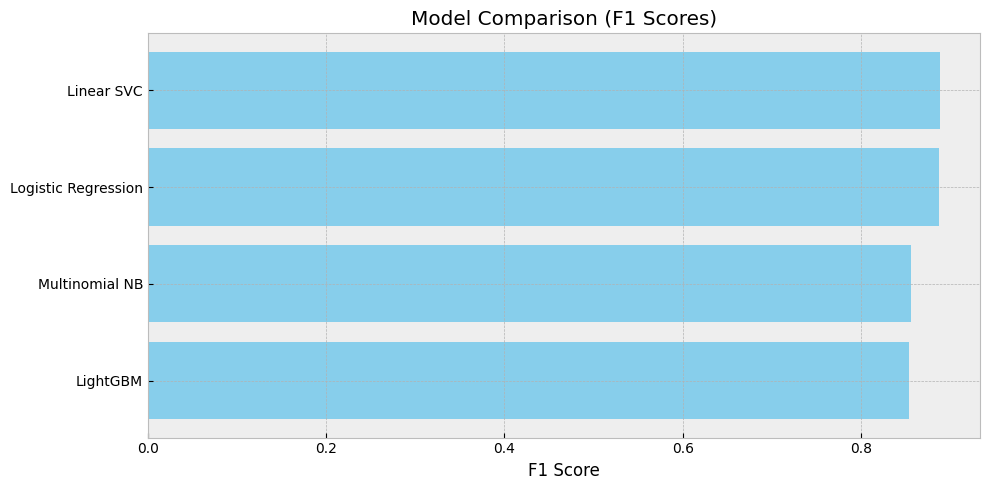

In [25]:
run_text_classification_pipeline(X_train, X_val, y_train, y_val)

As can be seen from the final graph, Logistic Regression and Linear SVC both performed well but Linear SVC was slightly better and thus I will be **choosing Linear SVC** for the hyper parameter tuning and then for final testing on full_train and test.

## Hyperparameter Tuning for Linear SVC

In [33]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['squared_hinge'],
    'max_iter': [1000, 2000],
    'tol': [1e-4, 1e-3]
}

svc = LinearSVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Best model
best_svc = grid_search.best_estimator_

# Evaluate
from sklearn.metrics import classification_report
y_pred = best_svc.predict(X_val)
print(classification_report(y_val, y_pred))
print("Best parameters:", grid_search.best_params_)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4940
           1       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Best parameters: {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}


Not that much of a difference, anyway, Linear SVC is now trained and tuned with the **final accuracy socre of 0.89**, which isn't that bad.

And now, I will train this model using the same parameters on the full_train and test dataset.

Parameters:
'C': 0.1,
'loss': 'squared_hinge',
'max_iter': 1000,
'tol': 0.0001

# Training Final Linear SVC

In [36]:
final_model = LinearSVC(C=1.0, loss='squared_hinge', max_iter=1000, tol=0.0001)
final_model.fit(X_full_train, y_full_train)

y_test_preds = final_model.predict(X_test)

print("Final Test Results:")
print("Accuracy :", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds))
print("Recall   :", recall_score(y_test, y_test_preds))
print("F1 Score :", f1_score(y_test, y_test_preds))

Final Test Results:
Accuracy : 0.8955329232630836
Precision: 0.8907396391037081
Recall   : 0.902551737994776
F1 Score : 0.8966067864271458


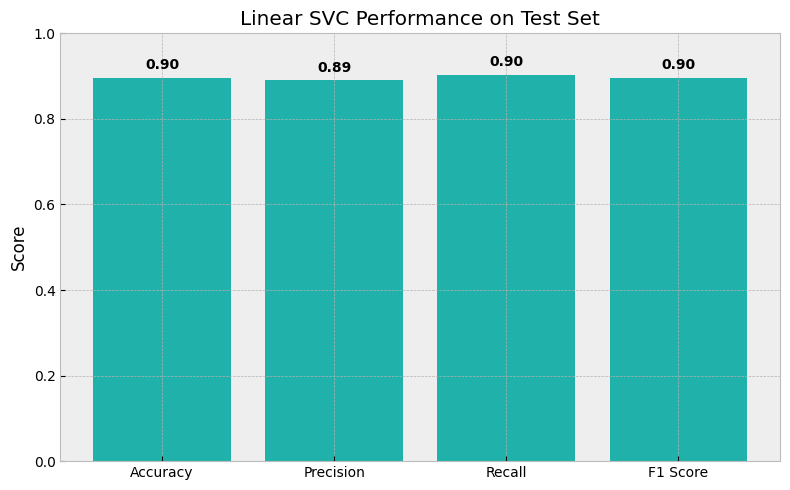

In [37]:
acc = accuracy_score(y_test, y_test_preds)
prec = precision_score(y_test, y_test_preds)
rec = recall_score(y_test, y_test_preds)
f1 = f1_score(y_test, y_test_preds)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [acc, prec, rec, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='lightseagreen')
plt.ylim(0, 1)
plt.title("Linear SVC Performance on Test Set")
plt.ylabel("Score")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Saving the Final Model

In [40]:
# Save the trained model
with open("linear_svc_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [42]:
# Save vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)